# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [10]:
from cs231n.features import *

num_color_bins = 12 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [14]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 5e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
import itertools

# 使用 itertools.product 生成所有参数组合
param_combinations = list(itertools.product(learning_rates, regularization_strengths))
for combo in param_combinations:
    print(combo)

    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=combo[0], reg=combo[1],
                        num_iters=3000, verbose=True)     # iters = 1500
    # plt.plot(loss_hist)
    # plt.xlabel('Iteration number')
    # plt.ylabel('Loss value')
    # plt.show()
    y_train_pred = svm.predict(X_train_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % (train_accuracy, ))
    y_val_pred = svm.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % (val_accuracy, ))
    
    results[combo] = (train_accuracy, val_accuracy)
    if best_val <= val_accuracy:
        best_val = val_accuracy
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(1e-09, 50000.0)
iteration 0 / 3000: loss 88.341162
iteration 100 / 3000: loss 86.773603
iteration 200 / 3000: loss 85.248939
iteration 300 / 3000: loss 83.748498
iteration 400 / 3000: loss 82.250295
iteration 500 / 3000: loss 80.802144
iteration 600 / 3000: loss 79.379881
iteration 700 / 3000: loss 77.983488
iteration 800 / 3000: loss 76.626671
iteration 900 / 3000: loss 75.269673
iteration 1000 / 3000: loss 73.972702
iteration 1100 / 3000: loss 72.679667
iteration 1200 / 3000: loss 71.429500
iteration 1300 / 3000: loss 70.187337
iteration 1400 / 3000: loss 68.972988
iteration 1500 / 3000: loss 67.769537
iteration 1600 / 3000: loss 66.623485
iteration 1700 / 3000: loss 65.485257
iteration 1800 / 3000: loss 64.360426
iteration 1900 / 3000: loss 63.266350
iteration 2000 / 3000: loss 62.192569
iteration 2100 / 3000: loss 61.144739
iteration 2200 / 3000: loss 60.101239
iteration 2300 / 3000: loss 59.099140
iteration 2400 / 3000: loss 58.104969
iteration 2500 / 3000: loss 57.134294
iterati

/Users/mercury/Desktop/my_space/02-talk_is_cheap/CS231n/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/Users/mercury/miniforge3/envs/cs231n_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mercury/Desktop/my_space/02-talk_is_cheap/CS231n/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/Users/mercury/Desktop/my_space/02-talk_is_cheap/CS231n/assignment1/cs231n/classifiers/linear_svm.py:112: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/Users/mercury/Desktop/my_space/02-talk_is_cheap/CS231n/assignment1/cs231n/classifiers/linear_classifier.py:72: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.121469 val accuracy: 0.113000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.113184 val accuracy: 0.105000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.417571 val accuracy: 0.425000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.088367 v

In [18]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


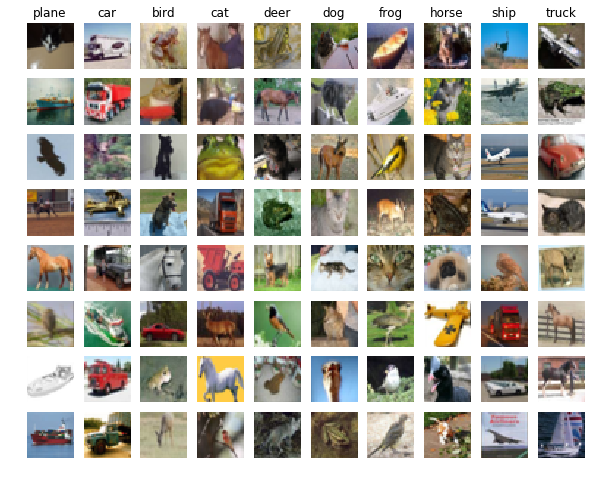

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

在观察到的误分类结果中，模型将一些实际不是飞机的图像错误地预测为飞机。这种情况可以从以下几个方面进行描述和分析：

1. **误分类的类型**：
   - 模型将某些图像（如汽车、鸟、船等）错误地标记为飞机。这表明模型在这些类别之间存在混淆。

2. **原因分析**：
   - **视觉特征相似性**：某些物体（如汽车或船）可能在形状、颜色或背景上与飞机有相似之处，导致模型难以区分。
   - **训练数据不足**：如果训练集中飞机的样本数量较少，或者样本多样性不足，模型可能无法学习到足够的特征来准确区分飞机与其他物体。
   - **特征提取不足**：使用的特征（如HOG和颜色直方图）可能未能充分捕捉到飞机的独特特征，导致模型在分类时出现错误。

3. **结果的合理性**：
   - 这些误分类结果在一定程度上是合理的，因为在现实世界中，物体之间的边界并不总是清晰的。模型在处理复杂的视觉信息时，可能会受到多种因素的影响。
   - 这种混淆也反映了模型的局限性，提示我们需要进一步改进特征提取方法或增加更多的训练数据，以提高分类准确性。

总结来说，模型的误分类结果是可以理解的，反映了特征提取和训练数据的不足。通过分析这些结果，我们可以找到改进模型的方向。

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [19]:
print(X_train_feats.shape)

(49000, 157)


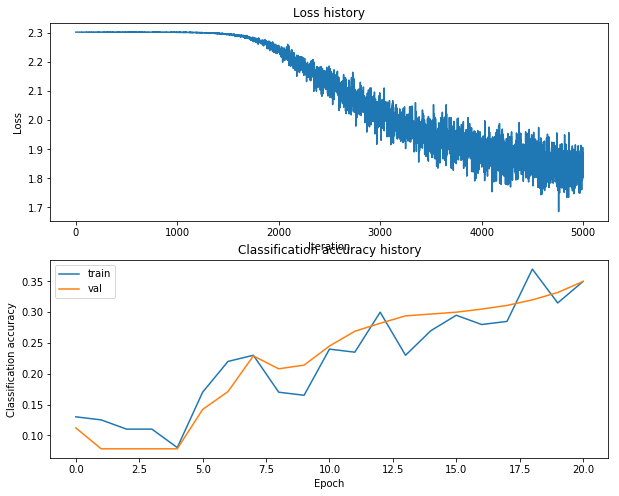

hidden_size: 1000, lr: 0.01, reg: 0.01, val_acc: 0.349
Best validation accuracy: 0.349


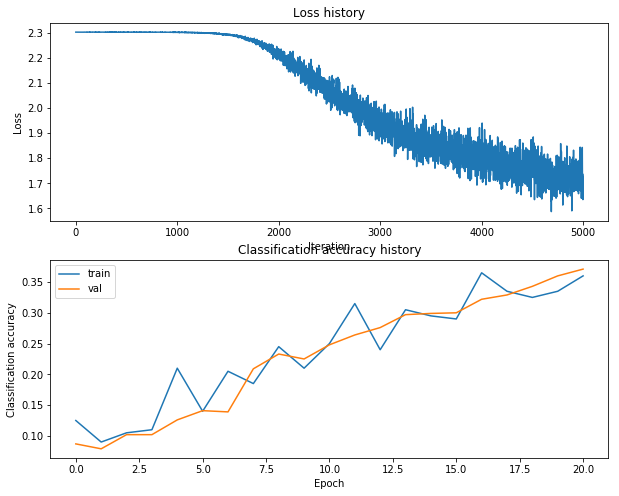

hidden_size: 1000, lr: 0.01, reg: 0.001, val_acc: 0.386
Best validation accuracy: 0.386


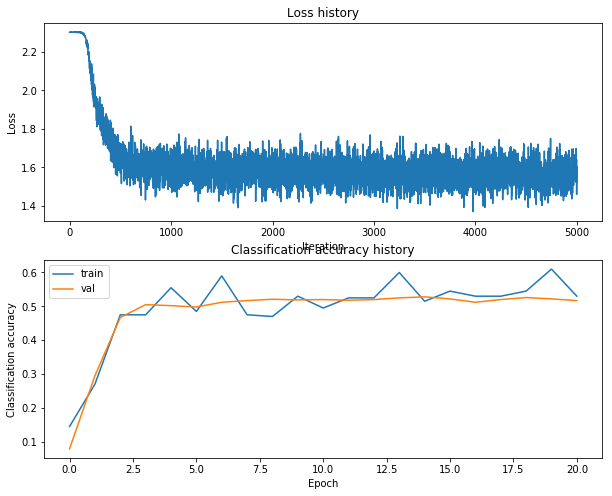

hidden_size: 1000, lr: 0.1, reg: 0.01, val_acc: 0.517
Best validation accuracy: 0.517


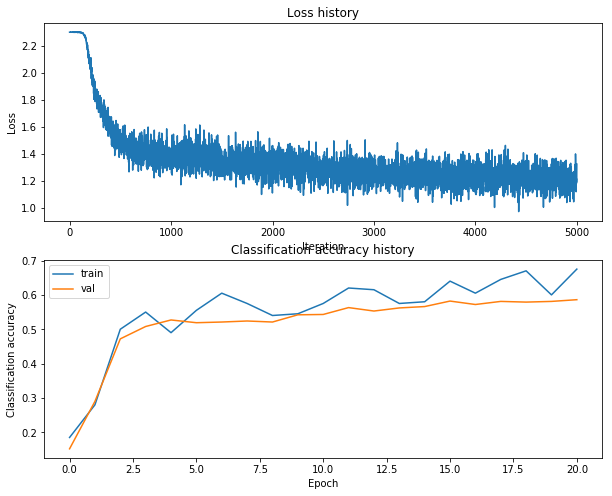

hidden_size: 1000, lr: 0.1, reg: 0.001, val_acc: 0.592
Best validation accuracy: 0.592
lr 1.000000e-02 reg 1.000000e-03 hidden_size 1000 val accuracy: 0.386000
lr 1.000000e-02 reg 1.000000e-02 hidden_size 1000 val accuracy: 0.349000
lr 1.000000e-01 reg 1.000000e-03 hidden_size 1000 val accuracy: 0.592000
lr 1.000000e-01 reg 1.000000e-02 hidden_size 1000 val accuracy: 0.517000


In [62]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
import itertools

# 定义超参数搜索范围
results = {}
hidden_sizes = [1000]
learning_rates = [1e-1]
regularization_strengths = [1e-3]
num_iters = 5000
batch_size = 200

best_val_acc = 0
best_net = None

# 使用 itertools.product 生成所有参数组合
param_combinations = list(itertools.product(learning_rates, regularization_strengths, hidden_sizes))
for combo in param_combinations:
    net = TwoLayerNet(input_dim, combo[2], num_classes, dropout_rate=0.5)

    # 训练网络
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=num_iters, batch_size=batch_size,
                learning_rate=combo[0], learning_rate_decay=0.95,
                reg=combo[1], verbose=False)

    # 在验证集上评估
    val_acc = (net.predict(X_val_feats) == y_val).mean()

    # 更新最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_net = net
    results[combo] = (val_acc)

    # Plot the loss function and train / validation accuracies
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()

    print(f'hidden_size: {combo[2]}, lr: {combo[0]}, reg: {combo[1]}, val_acc: {val_acc}')

    print('Best validation accuracy:', best_val_acc)

for lr, reg, hidden_size in sorted(results):
    val_accuracy = results[(lr, reg, hidden_size)]
    print('lr %e reg %e hidden_size %d val accuracy: %f' % (
                lr, reg, hidden_size, val_accuracy))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [63]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.565


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!